In [46]:
# Import necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

# Time Series Missing Value Imputation

### Generate data

,sales,ad_spent
date,,
2022-01-01,8.830262,6.593897
2022-01-02,41.116283,2.503652
2022-01-03,53.683909,0.000000
2022-01-04,NaN,0.000000
2022-01-05,-12.254839,0.000000


% missing data in sales:  24.10958904109589


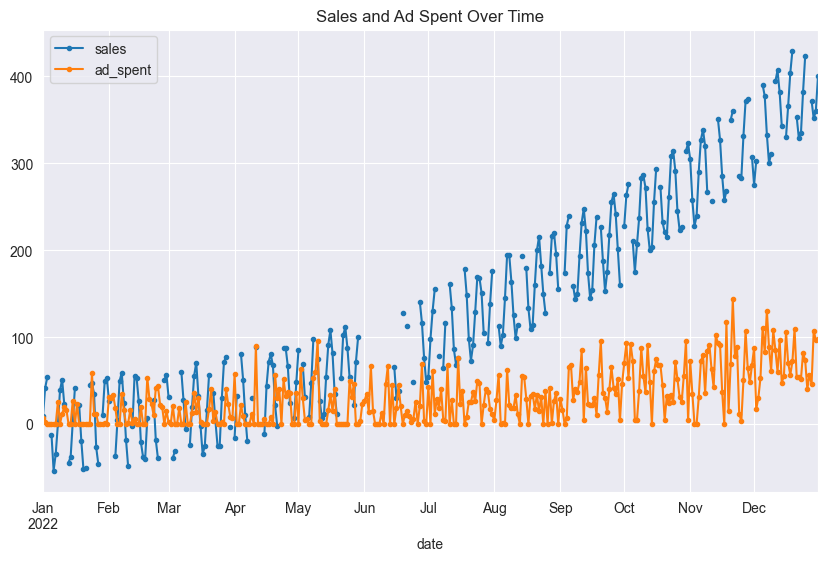

Correlation between sales and ad_spent:  0.6597259575886287


In [47]:
sns.set_style("darkgrid")
# Set the random seed for reproducibility
np.random.seed(0)

# Define the start date
start_date = datetime(2022, 1, 1)

# Generate dates for 365 days
dates = [start_date + timedelta(days=i) for i in range(365)]

# Generate more pronounced trend component (increasing linearly)
trend = np.power(np.linspace(0.1, 20, 365), 2)

# Generate more pronounced seasonal component (sinusoidal pattern) with weekly period
seasonal = 50 * np.sin(np.linspace(0, 2 * np.pi * 52, 365)) # 52 weeks in a year

# Generate random noise
noise = np.random.normal(0, 5, 365)

# Combine components to generate sales data
sales = trend + seasonal + noise

# Create ad_spent feature
# Using a scaled version of sales and adding more noise
ad_spent = 0.2 * sales + np.random.normal(0, 30, 365)  # Increased the noise and decreased the scale factor
ad_spent = np.maximum(ad_spent, 0)  # Making sure all ad_spent values are non-negative

# Create a dataframe
df = pd.DataFrame(
    {
        'date': dates,
        'sales': sales,
        'ad_spent': ad_spent
    }
)

# Set the date as the index
df.set_index('date', inplace=True)

# Generate missing values for a larger gap
for i in range(150, 165):  # A 15-day gap
    df.iloc[i, df.columns.get_loc('sales')] = np.nan

# Randomly choose indices for missing values (not including the already missing gap)
random_indices = random.sample(list(set(range(365)) - set(range(150,165))), int(0.20 * 365))

# Add random missing values
for i in random_indices:
    df.iloc[i, df.columns.get_loc('sales')] = np.nan

# Display the dataframe
display(df.head())

# Print the percentage of missing values 
print('% missing data in sales: ', 100*df['sales'].isnull().sum()/len(df))

# Plot the data
df[['sales', 'ad_spent']].plot(style='.-', figsize=(10,6), title='Sales and Ad Spent Over Time')
plt.show()

# Print correlation between sales and ad_spent
print("Correlation between sales and ad_spent: ", df['sales'].corr(df['ad_spent']))

### Deletion 

,sales,ad_spent
date,,
2022-01-01,8.830262,6.593897
2022-01-02,41.116283,2.503652
2022-01-03,53.683909,0.000000
2022-01-05,-12.254839,0.000000
2022-01-06,-53.493394,0.000000


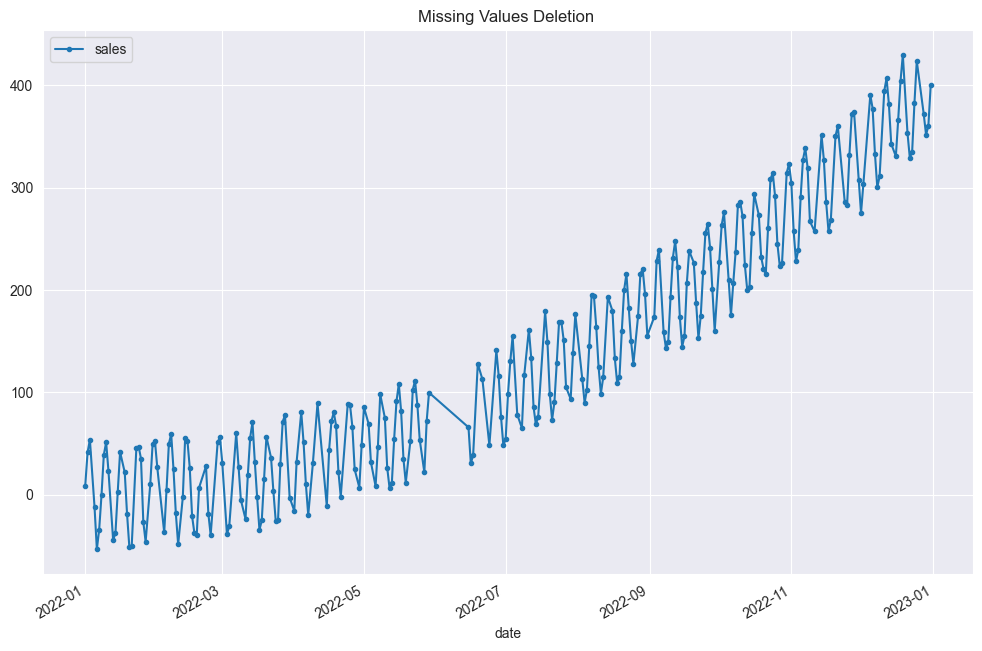

In [48]:
# Create a copy of the dataframe
df_deletion = df.copy()

# Remove rows with missing values
df_deletion.dropna(inplace=True)

# Display the dataframe
display(df_deletion.head())
# plot the data

df_deletion[['sales']].plot(style='.-', figsize=(12, 8), title='Missing Values Deletion ')
plt.show()

### Constant Imputation

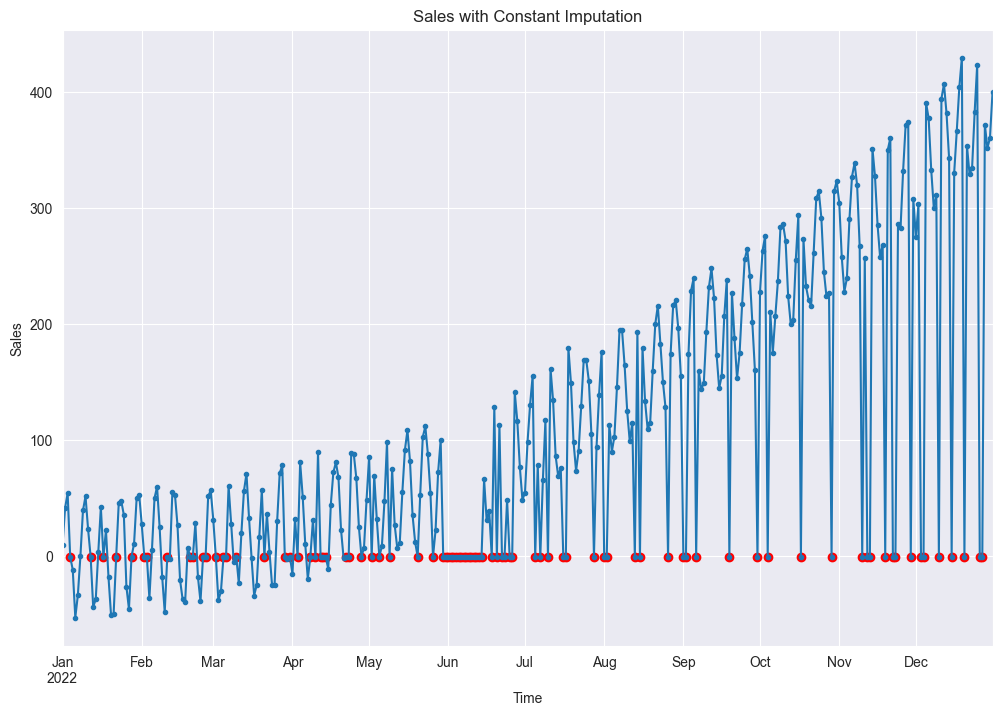

In [49]:
# Apply the forward fill method
df_imputed = df.fillna(-1)

# Plot the main line with markers
df_imputed['sales'].plot(style='.-', figsize=(12,8), title='Sales with Constant Imputation')

# Add points where data was imputed with red color
plt.scatter(df_imputed[df['sales'].isnull()].index, df_imputed[df['sales'].isnull()]['sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

### Last Observation Carried Forward (LOCF)

/var/folders/ry/5l37ld9j319_17ytxrp8r3r00000gn/T/ipykernel_97894/2308739173.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputed = df.fillna(method="ffill")


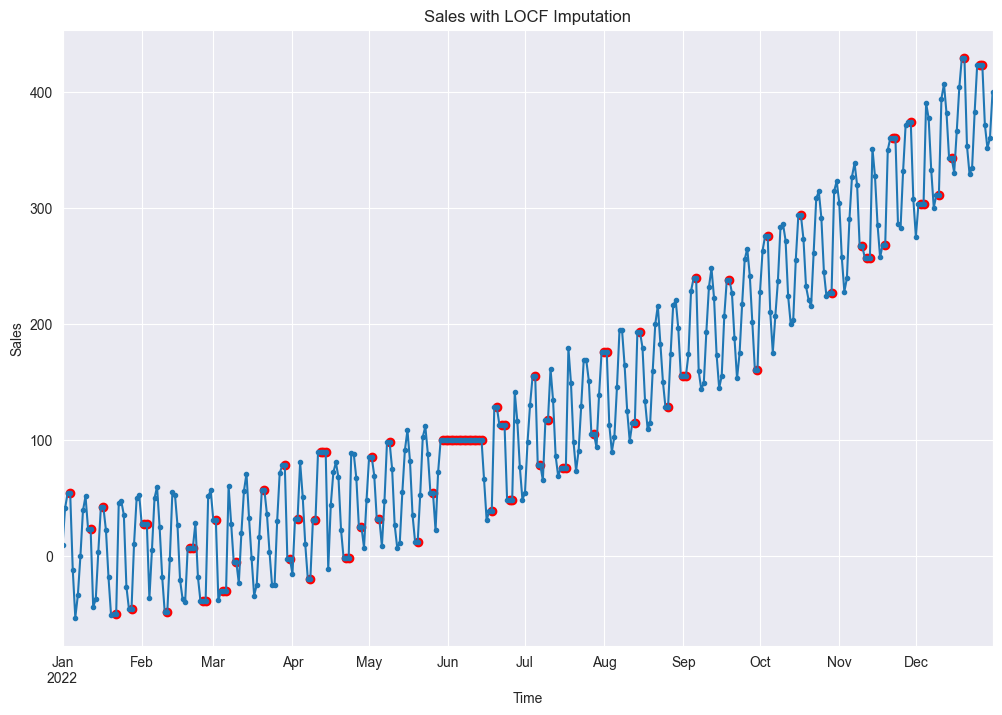

In [50]:
# Apply the forward fill method
df_imputed = df.fillna(method="ffill")

# Plot the main line with markers
df_imputed['sales'].plot(style='.-', figsize=(12,8), title='Sales with LOCF Imputation')

# Add points where data was imputed with red color
plt.scatter(df_imputed[df['sales'].isnull()].index, df_imputed[df['sales'].isnull()]['sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

### Next Observation Carried Backward (NOCB)

/var/folders/ry/5l37ld9j319_17ytxrp8r3r00000gn/T/ipykernel_97894/1235477071.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_imputed = df.fillna(method="bfill")


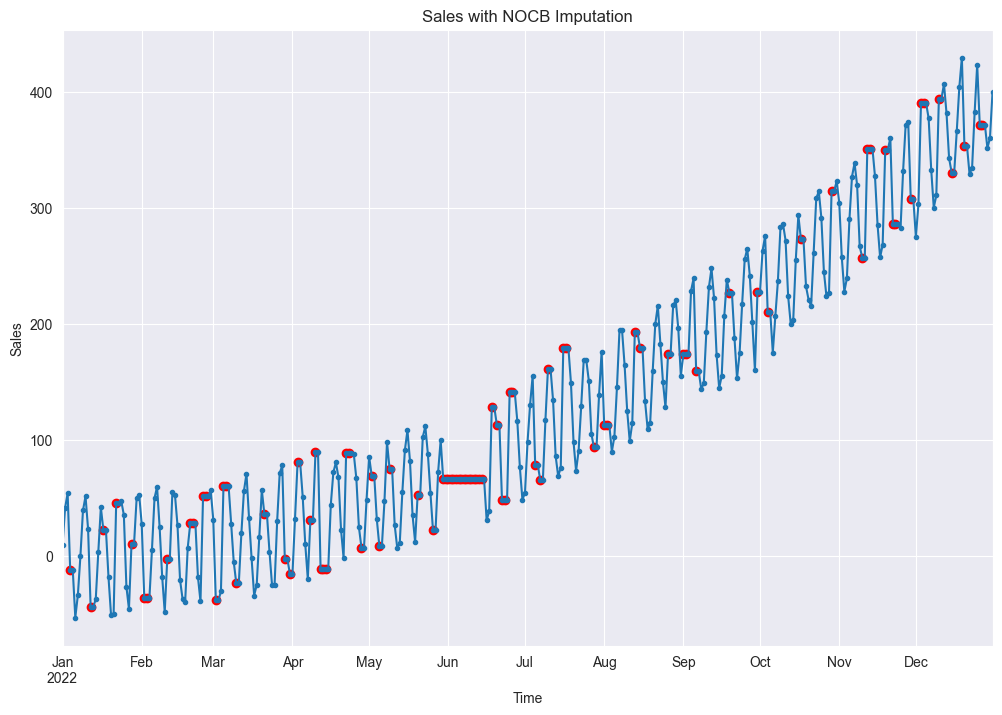

In [51]:
# Apply the backward fill method
df_imputed = df.fillna(method="bfill")

# Plot the main line with markers
df_imputed['sales'].plot(style='.-', figsize=(12,8), title='Sales with NOCB Imputation')

# Add points where data was imputed with red color
plt.scatter(df_imputed[df['sales'].isnull()].index, df_imputed[df['sales'].isnull()]['sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

### Mean/Median/Mode Imputation

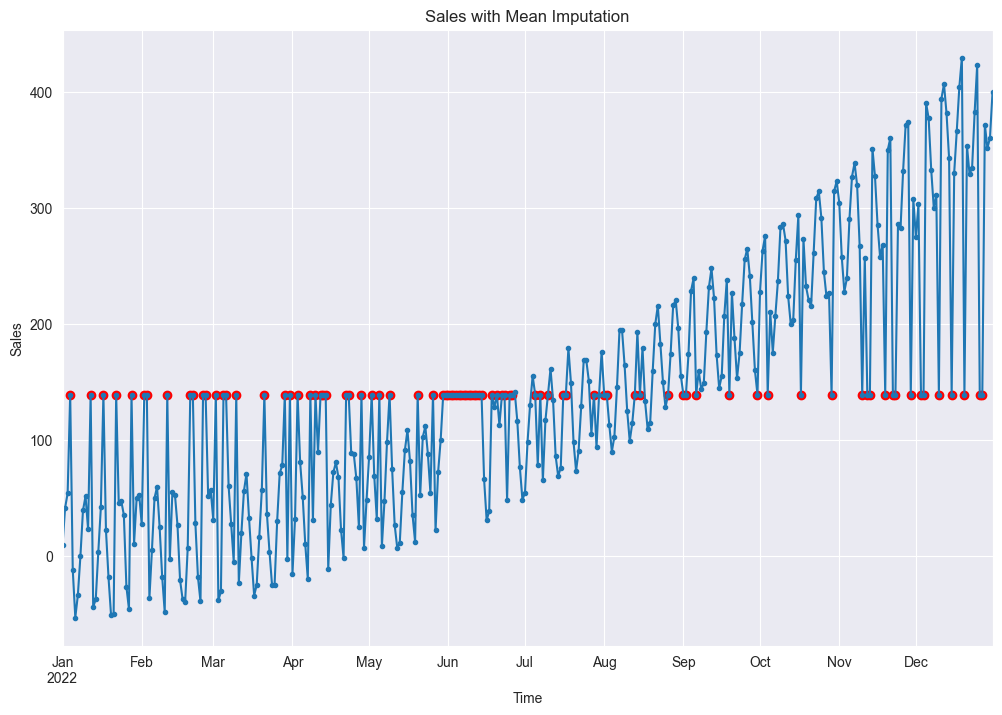

In [52]:
# Apply the mean imputation method
df_imputed = df.fillna(df['sales'].mean())

# Plot the main line with markers
df_imputed['sales'].plot(style='.-', figsize=(12,8), title='Sales with Mean Imputation')

# Add points where data was imputed with red color
imputed_indices = df[df['sales'].isnull()].index
plt.scatter(imputed_indices, df_imputed.loc[imputed_indices, 'sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

### Rolling Statistics Imputation

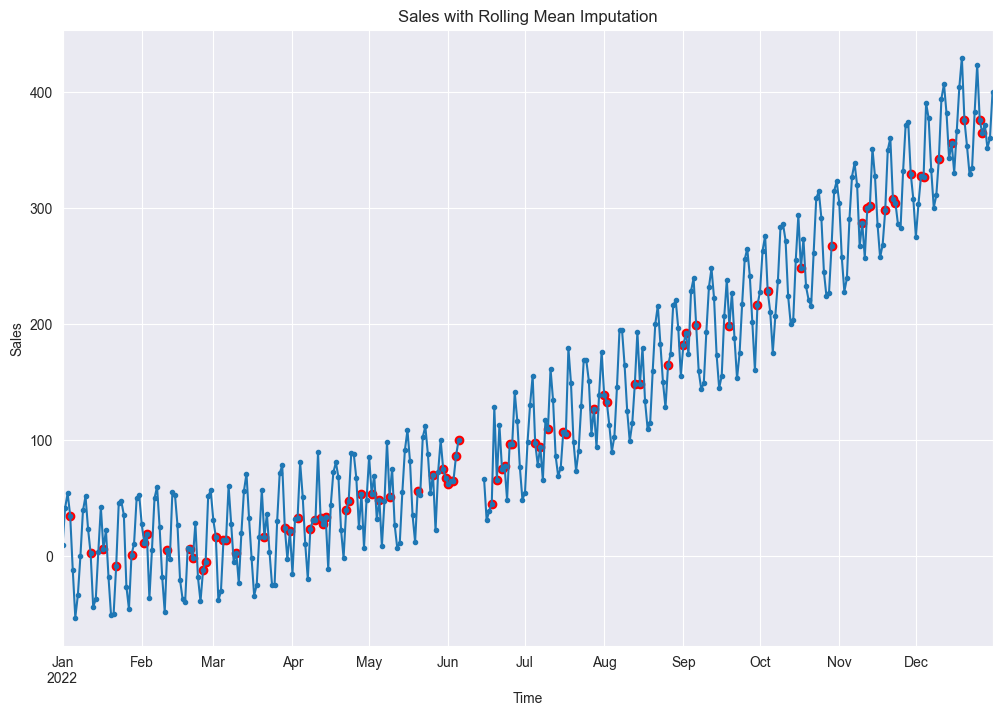

In [56]:
# Make a copy of the original DataFrame
df_copy = df.copy()

# Mark the missing values before imputation
imputed_indices = df_copy[df_copy['sales'].isnull()].index


# Apply the rolling mean imputation method
df_copy['sales'] = df_copy['sales'].fillna(df_copy['sales'].rolling(window=7, min_periods=1).mean().shift(1))

# Plot the main line with markers
df_copy['sales'].plot(style='.-', figsize=(12,8), title='Sales with Rolling Mean Imputation')

# Add points where data was imputed with red color
plt.scatter(imputed_indices, df_copy.loc[imputed_indices, 'sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

### Linear Interpolation

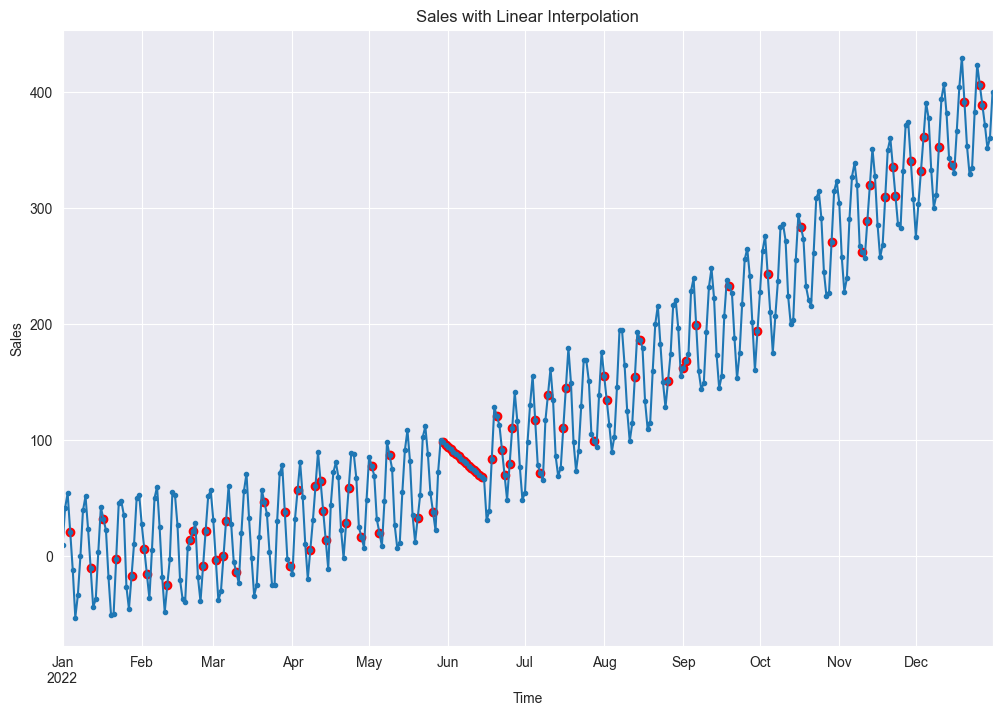

In [57]:
# Apply the linear interpolation method
df_imputed = df.interpolate(method ='linear', limit_direction ='forward')

# Plot the main line with markers
df_imputed['sales'].plot(style='.-', figsize=(12,8), title='Sales with Linear Interpolation')

# Add points where data was imputed with red color
imputed_indices = df[df['sales'].isnull()].index
plt.scatter(imputed_indices, df_imputed.loc[imputed_indices, 'sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

### Spline Interpolation

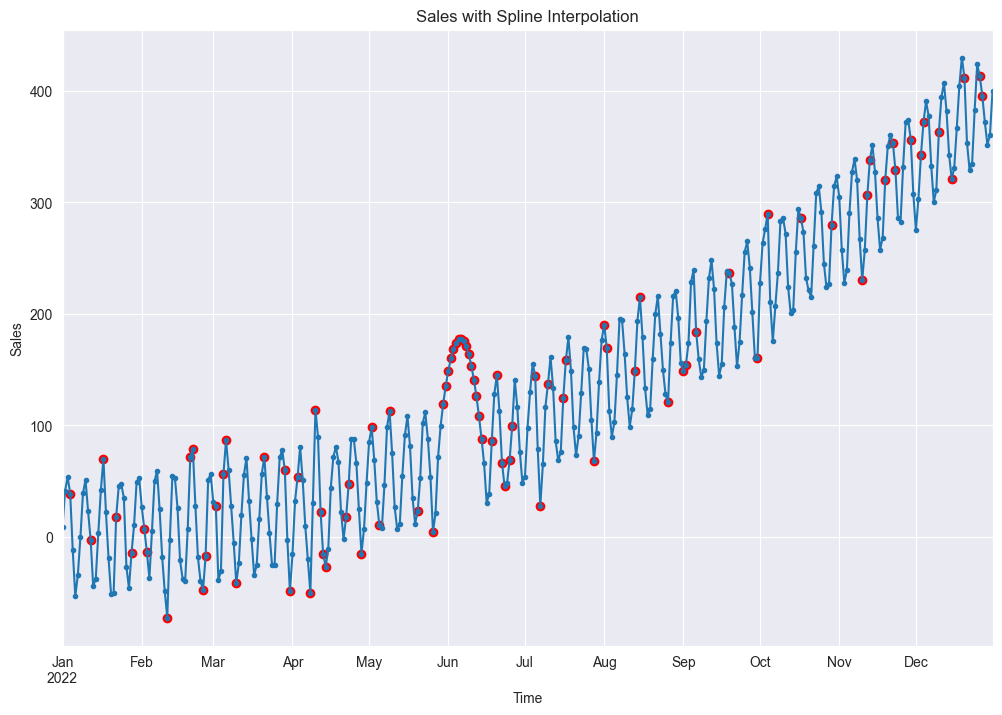

In [58]:
# Apply the spline interpolation method
df_imputed = df.interpolate(method='spline', limit_direction='forward', order=2)

# Plot the main line with markers
df_imputed['sales'].plot(style='.-', figsize=(12,8), title='Sales with Spline Interpolation')

# Add points where data was imputed with red color
imputed_indices = df[df['sales'].isnull()].index
plt.scatter(imputed_indices, df_imputed.loc[imputed_indices, 'sales'], color='red')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

### Regression Imputation

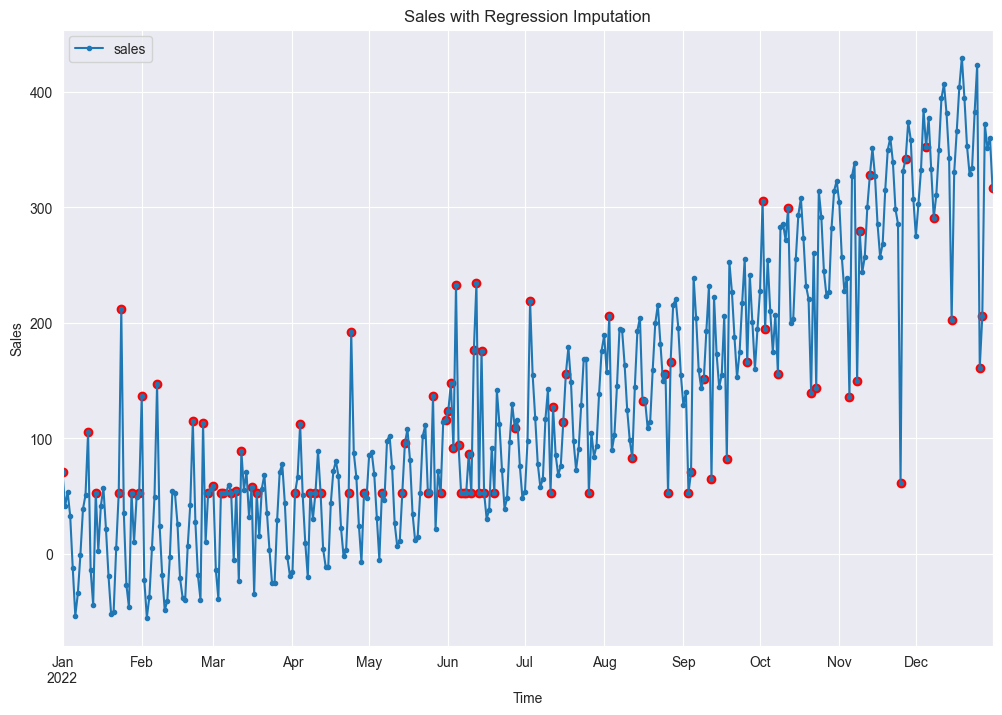

In [11]:
# Drop missing values to fit the regression model
df_imputed = df.copy()
df_non_missing = df.dropna()

# Instantiate the model
model = LinearRegression()

# Reshape data for model fitting (sklearn requires 2D array for predictors)
X = df_non_missing['ad_spent'].values.reshape(-1, 1)
Y = df_non_missing['sales'].values

# Fit the model
model.fit(X, Y)

# Get indices of missing sales
missing_sales_indices = df_imputed[df_imputed['sales'].isnull()].index

# Predict missing sales values
predicted_sales = model.predict(df_imputed.loc[missing_sales_indices, 'ad_spent'].values.reshape(-1, 1))

# Fill missing sales with predicted values
df_imputed.loc[missing_sales_indices, 'sales'] = predicted_sales

# Plot the main line with markers
df_imputed[['sales']].plot(style='.-', figsize=(12,8), title='Sales with Regression Imputation')

# Add points where data was imputed with red color
plt.scatter(missing_sales_indices, predicted_sales, color='red', label='Regression Imputation')

# Set labels
plt.xlabel('Time')
plt.ylabel('Sales')

plt.show()

### K-Nearest Neighbors (KNN) Imputation

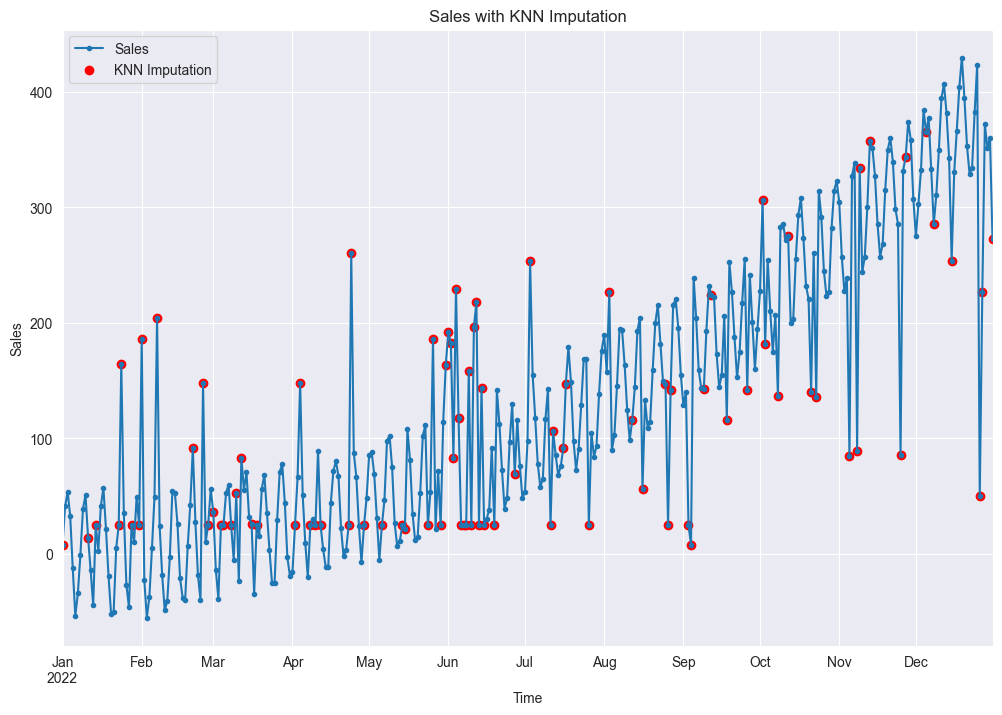

In [12]:
# Initialize the KNN imputer with k=5
imputer = KNNImputer(n_neighbors=3)

# Apply the KNN imputer
# Note: the KNNImputer requires 2D array-like input, hence the double brackets.
df_imputed = df.copy()
df_imputed[['sales', 'ad_spent']] = imputer.fit_transform(df_imputed[['sales', 'ad_spent']])

# Create a matplotlib plot
plt.figure(figsize=(12,8))
df_imputed['sales'].plot(style='.-', label='Sales')

# Add points where data was imputed
imputed_indices = df[df['sales'].isnull()].index
plt.scatter(imputed_indices, df_imputed.loc[imputed_indices, 'sales'], color='red', label='KNN Imputation')

# Set title and labels
plt.title('Sales with KNN Imputation')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Seasonal Trend Decomposition using Loess (STL) Imputation

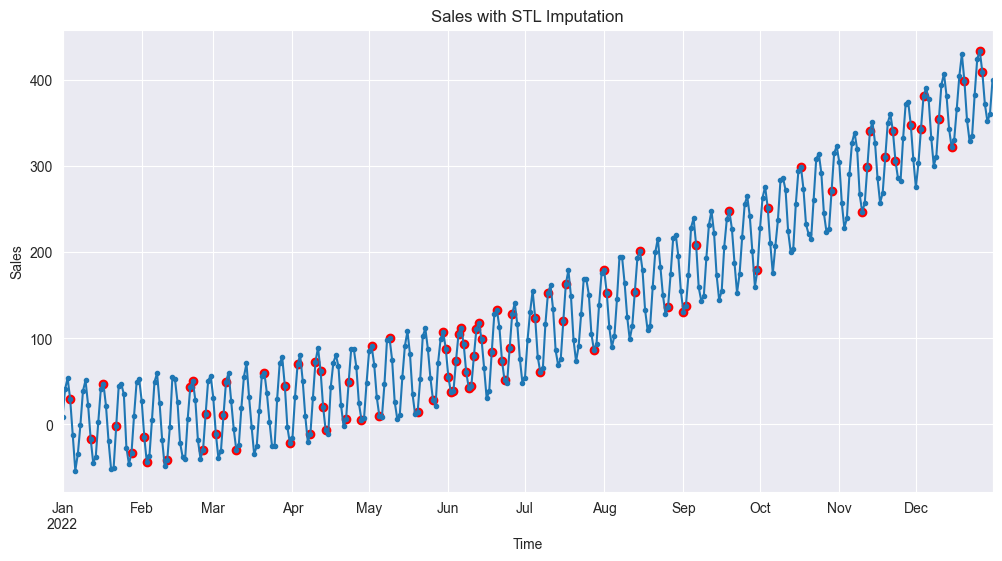

In [59]:
# Make a copy of the original dataframe
df_copy = df.copy()

# Fill missing values in the time series
imputed_indices = df[df['sales'].isnull()].index
# Apply STL decompostion
stl = STL(df_copy['sales'].interpolate(), seasonal=31)
res = stl.fit()

# Extract the seasonal and trend components
seasonal_component = res.seasonal

# Create the deseasonalised series
df_deseasonalised = df_copy['sales'] - seasonal_component

# Interpolate missing values in the deseasonalised series
df_deseasonalised_imputed = df_deseasonalised.interpolate(method="linear")

# Add the seasonal component back to create the final imputed series
df_imputed = df_deseasonalised_imputed + seasonal_component

# Update the original dataframe with the imputed values
df_copy.loc[imputed_indices, 'sales'] = df_imputed[imputed_indices]

# Plot the series using pandas
plt.figure(figsize=[12, 6])
df_copy['sales'].plot(style='.-',  label='Sales')
plt.scatter(imputed_indices, df_copy.loc[imputed_indices, 'sales'], color='red')

plt.title("Sales with STL Imputation")
plt.ylabel("Sales")
plt.xlabel("Time")
plt.show()

# Time Series Outlier Detection and Imputation

### Generate data

,sales
date,
2022-01-01,8.830262
2022-01-02,41.116283
2022-01-03,53.683909
2022-01-04,32.968355
2022-01-05,-12.254839


% missing data in sales:  0.0


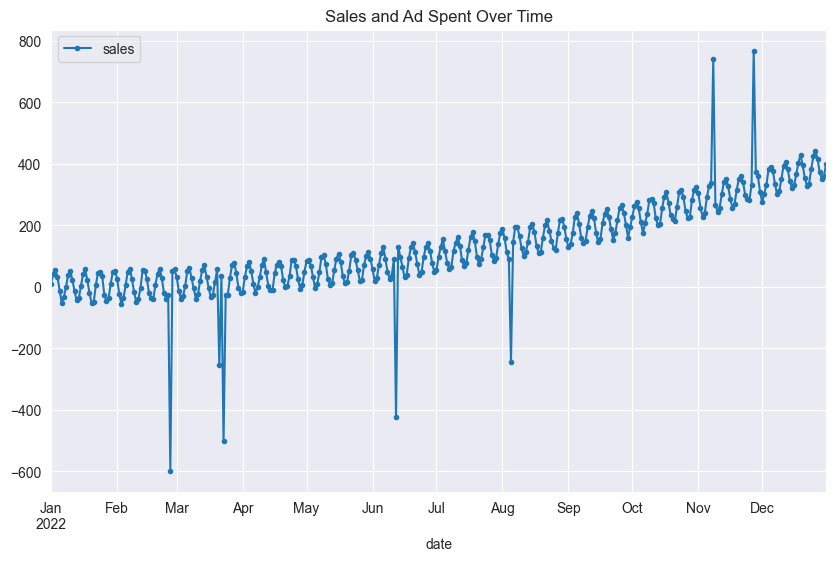

In [60]:
sns.set_style("darkgrid")
# Set the random seed for reproducibility
np.random.seed(0)

# Define the start date
start_date = datetime(2022, 1, 1)

# Generate dates for 365 days
dates = [start_date + timedelta(days=i) for i in range(365)]

# Generate more pronounced trend component (increasing linearly)
trend = np.power(np.linspace(0.1, 20, 365), 2)

# Generate more pronounced seasonal component (sinusoidal pattern) with weekly period
seasonal = 50 * np.sin(np.linspace(0, 2 * np.pi * 52, 365)) # 52 weeks in a year

# Generate random noise
noise = np.random.normal(0, 5, 365)

# Combine components to generate sales data
sales = trend + seasonal + noise

# Create a dataframe
df = pd.DataFrame(
    {
        'date': dates,
        'sales': sales,
        # 'ad_spent': ad_spent
    }
)

# Set the date as the index
df.set_index('date', inplace=True)

# Randomly choose indices for outliers
random_indices = random.sample(list(set(range(365))), int(0.02 * 365))

# Add random outliers
offset = np.max(df['sales'])-np.mean(df['sales'])
mean_value = np.mean(df['sales'])
for i in random_indices:
    if df.iloc[i, df.columns.get_loc('sales')] <= mean_value:
        df.iloc[i, df.columns.get_loc('sales')] = df.iloc[i, df.columns.get_loc('sales')] - (1+random.random())*offset
    else:
        df.iloc[i, df.columns.get_loc('sales')] = df.iloc[i, df.columns.get_loc('sales')] + (1+random.random())*offset

# Display the dataframe
display(df.head())

# Print the percentage of missing values 
print('% missing data in sales: ', 100*df['sales'].isnull().sum()/len(df))

# Plot the data
df[['sales']].plot(style='.-', figsize=(10,6), title='Sales and Ad Spent Over Time')
plt.show()

### Box plots

<Axes: ylabel='sales'>

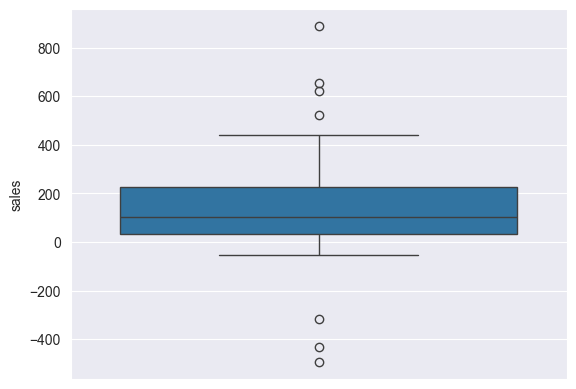

In [15]:
sns.boxplot(df['sales'])

### Inter-Quartile Range

,sales,origin_sales
date,,
2022-01-01,8.830262,8.830262
2022-01-02,41.116283,41.116283
2022-01-03,53.683909,53.683909
2022-01-04,32.968355,32.968355
2022-01-05,-12.254839,-12.254839


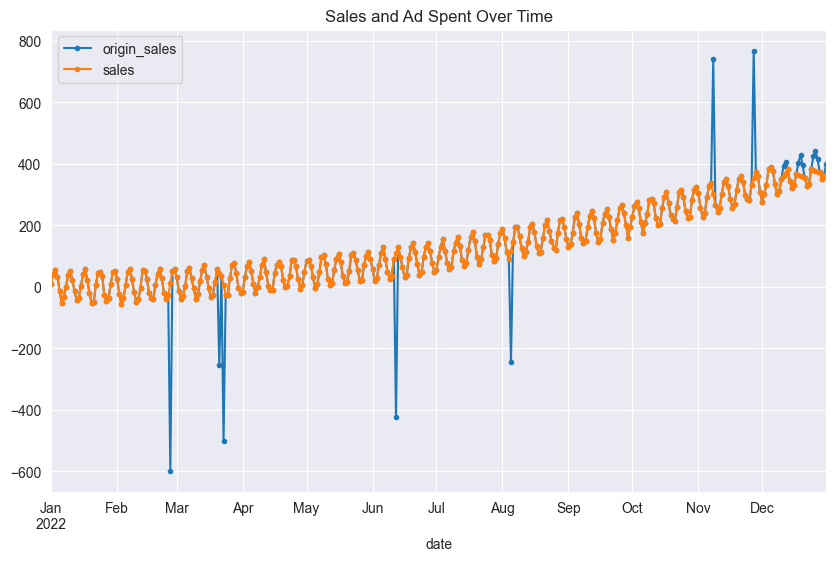

In [62]:
from numpy import NaN
IQR = np.quantile(df['sales'],0.75)-np.quantile(df['sales'],0.25)
outliers = df[(df.values > np.median(df['sales']) + 1.5*IQR) | (df.values < np.median(df['sales']) - 1.5*IQR)].values
df_with_NaNs = df.replace(outliers, NaN)
df_new = df_with_NaNs.interpolate(method='linear', axis=0).ffill().bfill()
df_new['origin_sales'] = df['sales']

# Display the dataframe
display(df_new.head())

# Plot the data
df_new[['origin_sales', 'sales']].plot(style='.-', figsize=(10,6), title='Sales and Ad Spent Over Time')
plt.show()

### Z Score

,sales,origin_sales
date,,
2022-01-01,8.830262,8.830262
2022-01-02,41.116283,41.116283
2022-01-03,53.683909,53.683909
2022-01-04,32.968355,32.968355
2022-01-05,-12.254839,-12.254839


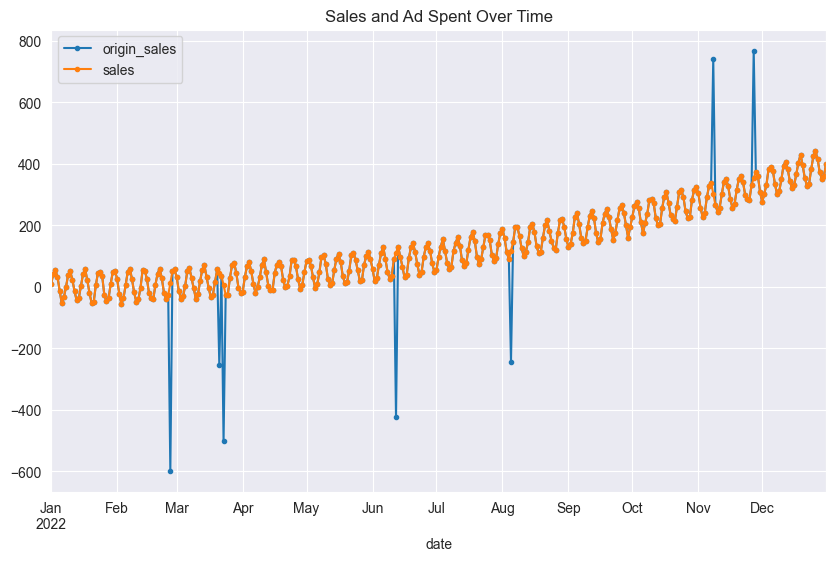

In [65]:
from scipy import stats
z_scores = stats.zscore(df['sales'])
z_scores
threshold = 2.36
outliers = df[abs(z_scores.values) > threshold].values

df_with_NaNs = df.replace(outliers, NaN)
df_new = df_with_NaNs.interpolate(method='linear', axis=0).ffill().bfill()
df_new['origin_sales'] = df['sales']

# Display the dataframe
display(df_new.head())

# Plot the data
df_new[['origin_sales', 'sales']].plot(style='.-', figsize=(10,6), title='Sales and Ad Spent Over Time')
plt.show()

# Time Series Decomposition

### Additive Decomposition

,sales
date,
2022-01-01,8.830262
2022-01-02,41.116283
2022-01-03,53.683909
2022-01-04,32.968355
2022-01-05,-12.254839


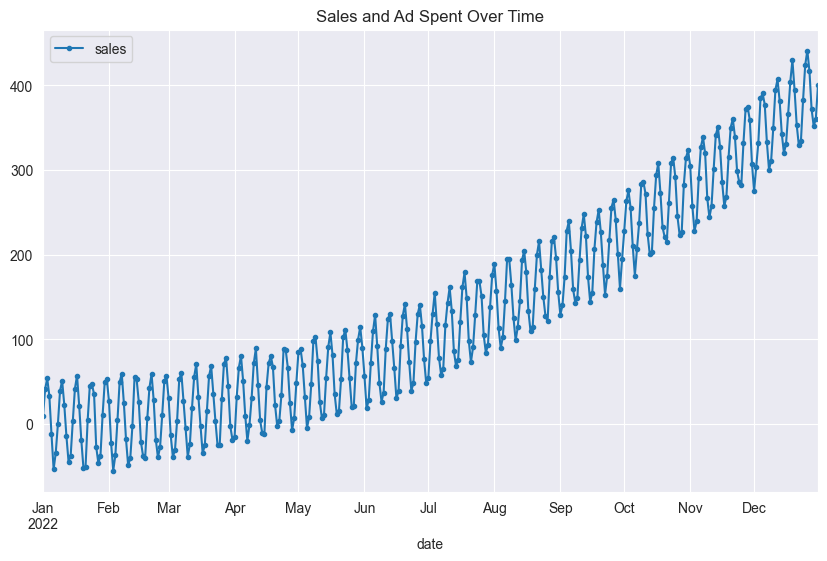

In [66]:
sns.set_style("darkgrid")
# Set the random seed for reproducibility
np.random.seed(0)

# Define the start date
start_date = datetime(2022, 1, 1)

# Generate dates for 365 days
dates = [start_date + timedelta(days=i) for i in range(365)]

# Generate more pronounced trend component (increasing linearly)
trend = np.power(np.linspace(0.1, 20, 365), 2)

# Generate more pronounced seasonal component (sinusoidal pattern) with weekly period
seasonal = 50 * np.sin(np.linspace(0, 2 * np.pi * 52, 365)) # 52 weeks in a year

# Generate random noise
noise = np.random.normal(0, 5, 365)

# Combine components to generate sales data
sales = trend + seasonal + noise

# Create a dataframe
df = pd.DataFrame(
    {
        'date': dates,
        'sales': sales,
        # 'ad_spent': ad_spent
    }
)

# Set the date as the index
df.set_index('date', inplace=True)

# Display the dataframe
display(df.head())

# Plot the data
df[['sales']].plot(style='.-', figsize=(10,6), title='Sales and Ad Spent Over Time')
plt.show()

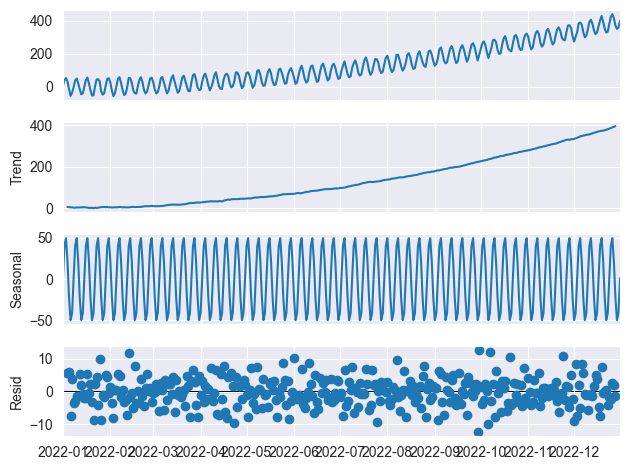

In [67]:
result = seasonal_decompose(df[['sales']], model='additive', period=7)
result.plot()
plt.show()

### Multiplicative Decomposition

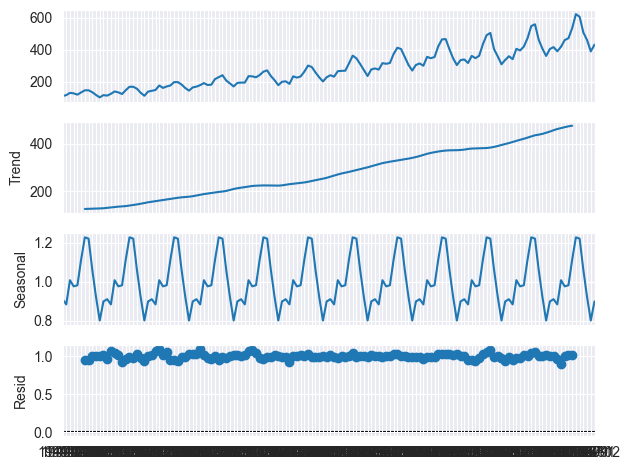

In [22]:
series = pd.read_csv('airline-passengers.txt', header=0, index_col=0)
result = seasonal_decompose(series, model='multiplicative',period=12)
result.plot()
plt.show()

### STL

In [68]:
# Apply STL decomposition
stl = STL(df, seasonal=7)
result = stl.fit()

# Extract the components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

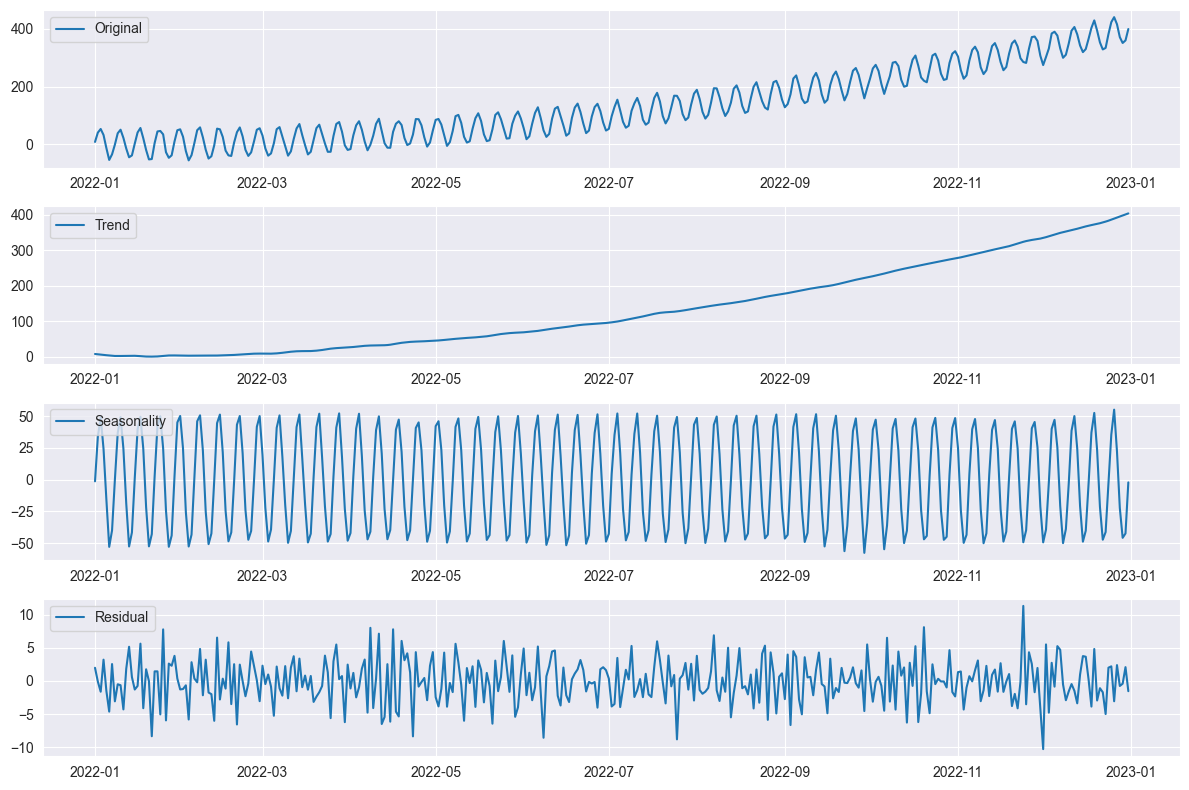

In [69]:
# Plot the original time series and the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
plt.plot(df, label='Original')
plt.legend(loc='upper left')
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper left')
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Walmart Store Sales Forecasting

In [70]:
df = pd.read_csv('../walmart-recruiting-store-sales-forecasting/train.csv')
print(df.shape)
df.head()

(421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [71]:
np.sum(df.isna())

/Users/lezhang/Documents/learning/repos/venv/genai-venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [72]:
df['Date'].value_counts()

Date
2011-12-23    3027
2011-11-25    3021
2011-12-16    3013
2011-12-09    3010
2012-02-17    3007
              ... 
2010-07-09    2903
2010-07-16    2901
2010-08-20    2901
2010-08-27    2898
2010-08-13    2896
Name: count, Length: 143, dtype: int64